# Simple 2 Moving Average Model

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import date, timedelta

Downloading Data:

In [2]:
#all inputs
ticker = "SPY"
#YYYY-MM-DD
start = "2015-04-25"
#moving Averages, MA1 is typically smaller than MA2
MA1 = "20"
MA2 = "50"

#model trading days input in days, standard 1Y is 252 days. Can use multiples of 252 to track years
model_days = 252 * 1


#fixed end date of today - 1 day
end = str(date.today() - timedelta(1))

#multi_level_index = False removes ticker noise in table
df = yf.download(ticker, start, end, multi_level_index = False)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Formatting Table:

In [3]:
#adding day count
day_count = np.arange(1, len(df) + 1)
df['Day Count'] = day_count

#dropping volume column
df.drop(columns=['Volume'], inplace = True)

#ordering the table
df = round(df[['Day Count', 'Open', 'High', 'Low', 'Close']], 2)

Adding MAs:

In [4]:
df[f'{MA1}-day MA'] = df['Close'].rolling(int(MA1)).mean().shift()
df[f'{MA2}-day MA'] = df['Close'].rolling(int(MA2)).mean().shift()
#we .shift() to push the moving average forward a day because the moving average cannot start until x days have finished

Adding Signals:

In [5]:
#signal to long
df['Signal'] = np.where(df[f'{MA1}-day MA'] > df[f'{MA2}-day MA'], 1, 0)

#signal to short
df['Signal'] = np.where(df[f'{MA1}-day MA'] < df[f'{MA2}-day MA'], -1, df['Signal'])

Returns:

In [6]:
#create returns and the model returns colummns
# the difference between the current row ln and previous row ln gives a daily return
df['Daily Return'] = np.log(df['Close']).diff()

# model return, if our signal is - we are short and the daily return is negative. vice versa
df['Model Return'] = df['Daily Return'] * df['Signal']

#entry column for visualization
df['Entry'] = df.Signal.diff()
df.dropna(inplace=True)

Creating Moving Average Cross-Over Grid Visualization

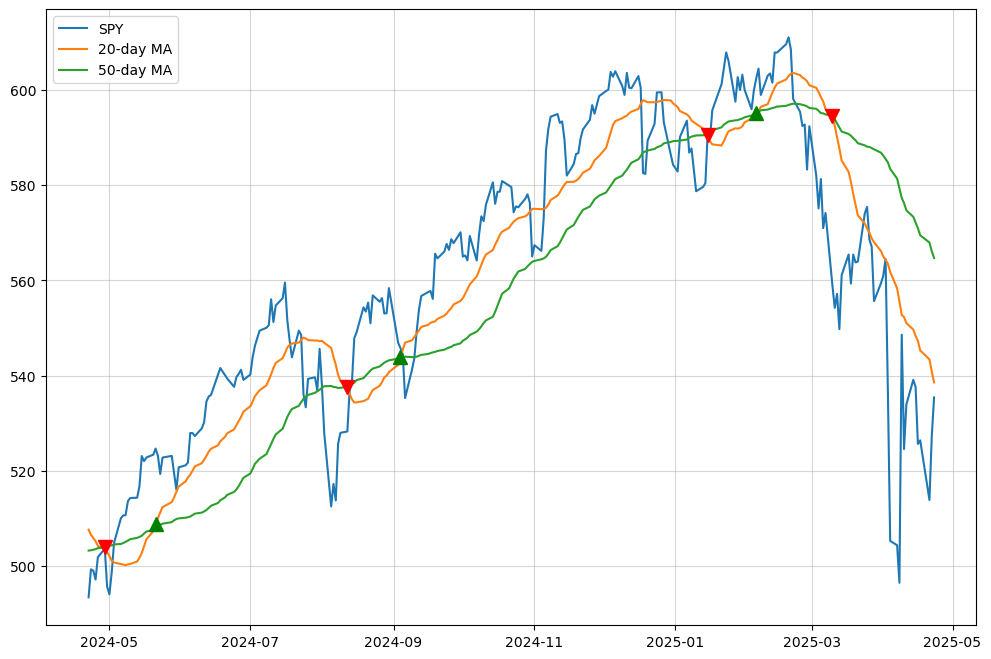

In [7]:
#parameters for grid size
plt.rcParams['figure.figsize'] = 12, 8
#create grid
plt.grid(True, alpha = .5)
#plot ticker closing prices and MAs, .iloc for integers
plt.plot(df.iloc[-model_days:]['Close'], label = f'{ticker.upper()}')
plt.plot(df.iloc[-model_days:][f'{MA1}-day MA'], label = f'{MA1}-day MA')
plt.plot(df.iloc[-model_days:][f'{MA2}-day MA'], label = f'{MA2}-day MA')
#plotting entry points, .loc for labels
plt.plot(df[-model_days:].loc[df.Entry == 2].index, df[-model_days:][f'{MA1}-day MA'][df.Entry == 2], '^', color = 'g', markersize = 10)
plt.plot(df[-model_days:].loc[df.Entry == -2].index, df[-model_days:][f'{MA2}-day MA'][df.Entry == -2], 'v', color = 'r', markersize = 10)
#plot legend
plt.legend(loc=2)

Creating Buy/Hold Comparison to MA Crossover Strategy

In [8]:
df['Cumulative Return'] = (np.exp(df['Daily Return']).cumprod() - 1) * 100
df['Cumulative Model Return'] = (np.exp(df['Model Return']).cumprod() - 1) * 100
df

,Day Count,Open,High,Low,Close,20-day MA,50-day MA,Signal,Daily Return,Model Return,Entry,Cumulative Return,Cumulative Model Return
Date,,,,,,,,,,,,,
2015-07-08,51,174.52,174.81,172.69,172.92,176.7595,177.2502,-1,-0.016916,0.016916,-1.0,-1.677375,1.705991
2015-07-09,52,175.05,175.31,173.13,173.24,176.6365,177.1618,-1,0.001849,-0.001849,0.0,-1.495423,1.518125
2015-07-10,53,175.26,175.84,173.28,175.42,176.4240,177.0686,-1,0.012505,-0.012505,0.0,-0.255871,0.256527
2015-07-13,54,176.69,177.46,176.65,177.35,176.2920,177.0336,-1,0.010942,-0.010942,0.0,0.841531,-0.834508
2015-07-14,55,177.31,178.44,177.25,178.12,176.3245,177.0728,-1,0.004332,-0.004332,0.0,1.279354,-1.263193
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-16,2510,531.68,537.89,520.29,525.66,547.2830,570.9762,-1,-0.022479,0.022479,0.0,198.891226,36.858319
2025-04-17,2511,527.64,531.17,523.91,526.41,545.2945,569.4898,-1,0.001426,-0.001426,0.0,199.317678,36.663331
2025-04-21,2512,521.16,521.70,508.46,513.88,543.4255,567.9698,-1,-0.024091,0.024091,0.0,192.193097,39.995610


Cumulative Buy/Hold Return: 204.44
Cumulative Model Return: 34.36


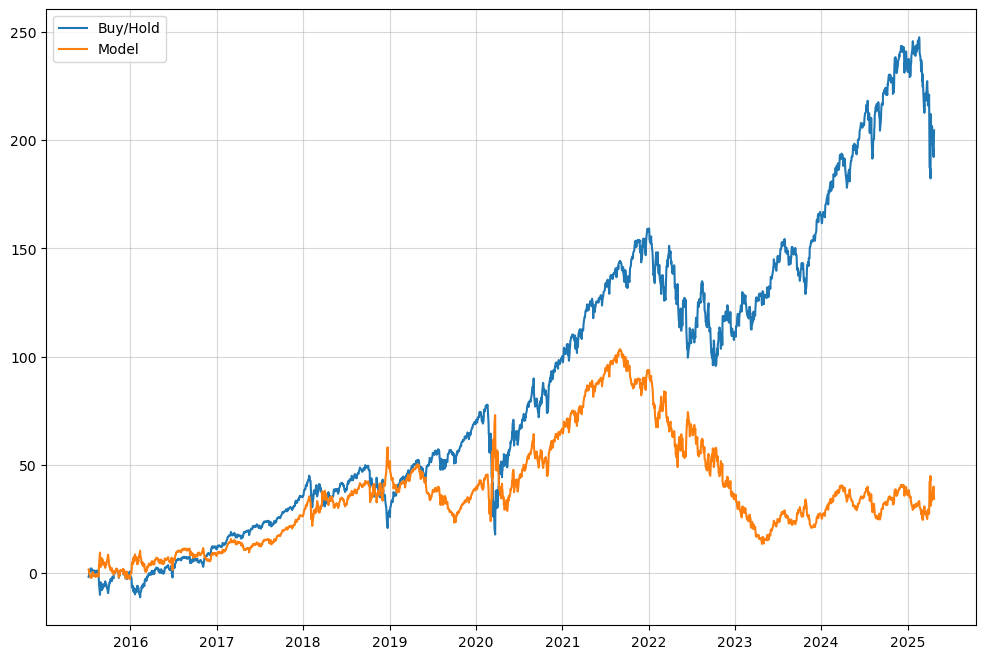

In [9]:
#buy/hold plot
plt.plot(df['Cumulative Return'], label='Buy/Hold')
#model plot
plt.plot(df['Cumulative Model Return'], label='Model')
plt.legend(loc=2)
plt.grid(True, alpha=.5)
#print returns
print("Cumulative Buy/Hold Return:", round(df['Cumulative Return'].iloc[-1], 2))
print("Cumulative Model Return:", round(df['Cumulative Model Return'].iloc[-1], 2))